<a href="https://colab.research.google.com/github/pieter98/question_metadata/blob/main/QM_notebooks/QM03_few_shot_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing different libraries**


In [ ]:
import pandas as pd   # open source data analysis and manipulation tool
import numpy as np    # extension of Python; using arrays and matrices and different mathematical functions
from random import seed   # initializing of the random number generator
from random import sample   # sample elements from the string, tuple, list, ...
import re

seed(42)
np.random.seed(42)

from sklearn.model_selection import train_test_split    # split arrays or matrices in train, test subsets
import matplotlib.pyplot as plt   # Matlab-like way of plotting

import gensim.downloader as api   # used for loading different models. Here: Word2VecKeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors   # Word embedding
from gensim.models import KeyedVectors

from sklearn.decomposition import PCA   # Principal Component Analysis: projecting data to a lower dimension
from sklearn.metrics import accuracy_score    # computing subset accuracy in multilabel classification
from sklearn.neighbors import KNeighborsClassifier    # KNN
from scipy import spatial                                   

from nltk.corpus import stopwords   # removing stopwords

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer   # Sentence embedding

!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# **Create the PyDrive client**
This is done for the set-up of a link between the Google colab notebook and Google drive. 

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# **Pre-trained model from Gensim**
A Dutch corpus on wikipedia data is used here to obtain word embeddings. It contains 320-dimensional embeddings. It's easy to shift between different languages by uploading the appropriate corpus. 
A multilingual transformer network is used to obtain 512-dimensional sentence embeddings. 


In [ ]:
#model0 = api.load('glove-twitter-25') 
#model1 = api.load('word2vec-google-news-300')

downloaded = drive.CreateFile({'id':"11CS9N5L5aQBz76jWOxNj7O1R686PTrld"})   # ID of the file on google drive
downloaded.GetContentFile('wikipedia-320.txt')    # Download the file from google drive to google colab
model2 = KeyedVectors.load_word2vec_format('wikipedia-320.txt')   # Dutch word embedding 

model3 = SentenceTransformer('distiluse-base-multilingual-cased-v1')   # sentence embedding

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

# **View CSV data set**
A relative small amount of data instances is manually labeled and presented in an comma-separated values file. 

In [ ]:
downloaded = drive.CreateFile({'id':"1QFwORycv4VrVWVyREzzjemwUr-VJMP-z"})   
downloaded.GetContentFile('Labeled_data.csv')
df = pd.read_csv("Labeled_data.csv",sep = ';')
df.head()

,Instruction,Label
0,Hoite Pruiksma een Nederlandse musicus heeft e...,Fysica
1,Duid het enige juiste antwoord aan Sommige ste...,Aardrijkskunde
2,Kies het enige juiste antwoord Kies de juiste ...,Geschiedenis
3,Een vat van 250 mL bevat 0374 g van een gasvor...,Chemie
4,Duid het enige juiste antwoord aan Naar welke ...,Biologie


# **Pre-processing the instruction texts**
All the instruction texts are cleaned up by removing different signs, new lines, etc.
Only the words, separated by a blank space, are returned.

In [ ]:
def get_only_chars(line):   # creating a definition to strip all instruction texts from not-alphabetic letters

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ")   # replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line)    # delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

#df['Instruction'] = df['Instruction'].apply(lambda x: get_only_chars(x))    # apply the function to each instance of the 'Instruction' column, only necessary when working with word embeddings

# **Defining the Query and Support set**
The Support set of the few-shot learning problem is defined here as the training set. The Support set consists of a number of examples of a specific class.
The Queries or the instances that need to be labeled are defined here as the test set.

In [ ]:
num_classes = 4   # amount of classes in the Support class
sample_size = 1   # amount of samples per Support class

df["Label"].replace({'Fysica':int(1), 'Aardrijkskunde':int(2), 'Biologie':int(3), 'Chemie':int(4), 'Geschiedenis':int(5)}, inplace=True)    # the labels need to be replaced by an integer for the gen_sample function

def gen_sample(sample_size, num_classes):
    df_1 = df[((df["Label"].astype(int)) < num_classes + 1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    train = df_1[df_1["Label"] == np.unique(df_1['Label'])[0]].sample(sample_size)    # support set

    train_index = train.index.tolist()

    for i in range(1,num_classes):
        train_2 = df_1[df_1["Label"] == np.unique(df_1['Label'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())

    test = df_1[~df_1.index.isin(train_index)]    # all the examples of the num_classes excluding the query

    return train, test

train, test = gen_sample(sample_size, num_classes)

X_train = train['Instruction']
y_train = train['Label'].values
X_test = test['Instruction']
y_test = test['Label'].values

In [ ]:
X_test

1     Duid het enige juiste antwoord aan Sommige ste...
2     Een vat van 250 mL bevat 0374 g van een gasvor...
3     Duid het enige juiste antwoord aan Naar welke ...
5     Duid het enige juiste antwoord aan Welke verge...
6     Duid per rij het enige juiste antwoord aan In ...
7     Het ICSH - hormoon wordt afgescheiden door de ...
8     Duid het enige juiste antwoord aan Welke volks...
9     Bekijk het filmpje Hoe kan je de werking van e...
10    Typ het antwoord in het lege vakOp een mooie z...
11    Duid het enige juiste antwoord aanBij bananenv...
12    Noteer de uitscheidingsorganen samen met hun u...
13    Wat is de eenheid van spanning?Duid het juiste...
14    Wat zijn de buurlanden van het gekleurde land?...
15    Duid het enige juiste antwoord aanDe plaatsfun...
16    Duid het enige juiste antwoord aanWelke Vlaams...
17    Om lampen parallel te schakelen worden deze aa...
18    Typ het antwoord in het lege vak In welk deel ...
19    Duid het enige juiste antwoord aanWat zijn

# **Word Embedding**
The embedding of each token is searched within the corpus. 
This is done by stripping the words from the instruction text that aren't within the corpus. The embeddings are than searched within the corpus. The mean of all these embeddings are calculated as a representation of the instruction text. 

In [ ]:
def transform_sentence1(text, model):

    def preprocess_text(raw_text, model=model):

        raw_text = raw_text.split()   # divides the string into substrings in a list 

        return list(filter(lambda x: x in model.vocab, raw_text))   # filter out the words that aren't in the models vocabulary

    tokens = preprocess_text(text)

    if not tokens:
        return np.zeros(model.vector_size)    # no words recognized by model, all values are zero

    text_vector = np.mean(model[tokens], axis=0)    # otherwise the mean of all the embeddings are calculated

    return np.array(text_vector)

X_train_mean = X_train.apply(lambda x : transform_sentence1(x, model2))  
X_test_mean = X_test.apply(lambda x : transform_sentence1(x, model2))

X_train_mean = pd.DataFrame(X_train_mean)['Instruction'].apply(pd.Series)
X_test_mean = pd.DataFrame(X_test_mean)['Instruction'].apply(pd.Series)

# **Sentence embedding**
The embedding of each instruction is computed through a transformer model. 

In [ ]:
def transform_sentence2(text, model):
  text_vector = model.encode(text)
  return np.array(text_vector)

X_train_mean = X_train.apply(lambda x : transform_sentence2(x, model3))  
X_test_mean = X_test.apply(lambda x : transform_sentence2(x, model3))

X_train_mean = pd.DataFrame(X_train_mean)['Instruction'].apply(pd.Series)
X_test_mean = pd.DataFrame(X_test_mean)['Instruction'].apply(pd.Series)

In [ ]:
X_test_mean

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
1,-0.014477,0.011849,0.035354,0.015653,0.034147,-0.005856,-0.034503,0.070120,0.006170,0.005643,...,-0.070834,0.016364,-0.033718,-0.028070,0.058371,-0.050314,0.017263,-0.028850,-0.048681,0.073053
2,-0.024124,-0.050552,-0.010184,-0.006836,-0.005716,0.033874,-0.042200,-0.036405,0.023374,-0.022115,...,0.037171,-0.039379,0.043095,-0.025703,0.010413,0.002103,0.015992,0.018576,-0.054190,0.033453
3,0.021445,-0.064973,-0.020086,0.011044,-0.001210,-0.080773,0.036471,0.020725,-0.018282,-0.020597,...,-0.050963,-0.001315,-0.027268,0.016628,-0.008629,-0.020503,-0.050943,0.045887,-0.046968,0.021141
5,-0.026465,0.056341,-0.050378,0.020442,0.029858,0.007592,-0.018076,-0.020911,0.030722,-0.002986,...,-0.015189,0.118353,0.019435,-0.004698,-0.031667,-0.001835,-0.005685,0.065773,0.031302,-0.016246
6,0.055090,-0.007973,0.037497,-0.004528,-0.040619,0.012483,0.040710,0.016768,-0.026953,0.018861,...,-0.009560,-0.000929,0.018996,0.045486,-0.021024,0.010890,-0.019076,0.013716,-0.024260,0.047823
7,0.036068,0.050669,-0.034846,0.046642,0.064609,-0.022523,-0.002622,0.077373,-0.041926,0.030139,...,-0.018814,0.042597,0.063464,-0.027971,0.044487,0.055835,-0.075350,-0.061041,-0.053874,-0.065150
8,-0.004402,0.041073,0.053010,-0.006798,0.024879,0.033065,-0.017164,-0.018269,0.014549,-0.018557,...,-0.052960,0.055163,-0.069677,-0.025643,-0.035415,-0.008400,0.019997,-0.067365,0.045226,0.001119
9,0.012174,-0.030193,-0.038004,-0.043598,0.008284,-0.029818,0.047363,-0.008622,-0.017615,-0.061280,...,0.009351,0.036479,0.092595,0.011758,0.015660,-0.049488,-0.011471,-0.012379,0.009488,-0.079829
10,0.030513,0.024666,0.011347,0.020077,0.041245,-0.011795,0.000471,-0.030323,0.014908,0.064953,...,-0.023313,0.021557,0.047688,-0.007372,0.059244,-0.013548,0.042878,-0.021596,0.027036,-0.031110
11,-0.044676,-0.054465,0.000135,-0.004319,0.058609,-0.062342,-0.004350,0.063580,-0.041750,0.058320,...,-0.010520,0.045783,-0.007095,-0.007136,0.018129,0.028291,-0.014434,-0.041965,-0.068187,0.027587


# **Similarity measures: Cosine similarity**
There are a lot of measures that can be used to calculate the similarity between an instance and each class within the support set. Here Cosine similarity is used.  

In [ ]:
def classify_cosine_txt(txt, mean_embedding):

    best_dist = 1
    best_label = -1

    for cl in range(len(mean_embedding)):
        dist = spatial.distance.cosine(transform_sentence2(txt, model3), mean_embedding[cl])  #calculating the cosine distance between 2 1-D arrays; respectively the embedding of the instruction text and the mean embedding of the class

        if dist < best_dist :
            best_dist = dist
            best_label = cl+1                                                                #+1 because cl starts with index 0

    return best_label

# **Similarity measures: Euclidean distance**
There are a lot of measures that can be used to calculate the similarity between an instance and each class within the support set. Here Euclidean distance is used.

In [ ]:
def classify_euclidean_txt(txt, mean_embedding):

    best_dist = 5
    best_label = -1

    for cl in range(len(mean_embedding)):
        dist = spatial.distance.euclidean(transform_sentence2(txt, model3), mean_embedding[cl])  #calculating the euclidean distance between 2 1-D arrays; respectively the embedding of the instruction text and the mean embedding of the class

        if dist < best_dist :
            best_dist = dist
            best_label = cl+1                                                                #+1 because cl starts with index 0

    return best_label

# **Similarity measures: Chebyshev distance**
There are a lot of measures that can be used to calculate the similarity between an instance and each class within the support set. Here Chebyshev distance is used.

In [ ]:
def classify_chebyshev_txt(txt, mean_embedding):

    best_dist = 1
    best_label = -1

    for cl in range(len(mean_embedding)):
        dist = spatial.distance.euclidean(transform_sentence2(txt, model3), mean_embedding[cl])  #calculating the chebyshev distance between 2 1-D arrays; respectively the embedding of the instruction text and the mean embedding of the class

        if dist < best_dist :
            best_dist = dist
            best_label = cl+1                                                                #+1 because cl starts with index 0

    return best_label

# **Accuracy**
A lot of the functions above are combined here. 
First the Query and Support set are calculated.
Secondly, the mean embeddings of the instruction texts are obtained. Based on the similarity measure outcome a prediction is made.
Return_score1 is used for the calculations with the average embedding of the support class, Return_score2 is used for the calculations with the KNN method on the support class.



In [ ]:
def return_score1(sample_size, num_classes, model, embedding, sim_func):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Instruction']
    y_train = train['Label'].values
    X_test = test['Instruction']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : embedding(x, model))
    X_test_mean = X_test.apply(lambda x : embedding(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Instruction'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Instruction'].apply(pd.Series)

    mean_embedding = {}
    for cl in range(num_classes):
        mean_embedding[cl] = np.mean((X_train_mean[y_train == cl + 1]), axis=0)
   

    y_pred = [sim_func(t, mean_embedding) for t in test['Instruction'].values]
    
    return accuracy_score(y_test.tolist(), y_pred)    # tolist because y_test is from the type numpy array

In [ ]:
def return_score2(sample_size, num_classes, model, embedding, sim_func):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Instruction']
    y_train = train['Label'].values
    X_test = test['Instruction']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : embedding(x, model))
    X_test_mean = X_test.apply(lambda x : embedding(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Instruction'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Instruction'].apply(pd.Series)

    clf = KNeighborsClassifier(n_neighbors=sample_size, p=2)    # KNN with Euclidean distance as similarity measure 
    clf.fit(X_train_mean.values.tolist(), y_train.tolist())   # train the KNN model; tolist because the types are different and have to be of the type list

    y_pred = clf.predict(X_test_mean.values.tolist())
    
    return accuracy_score(y_test.tolist(), y_pred) 

In [ ]:
return_score2(2,2,model3,transform_sentence2,classify_chebyshev_txt)

0.7692307692307693

# **Comparison and plot**

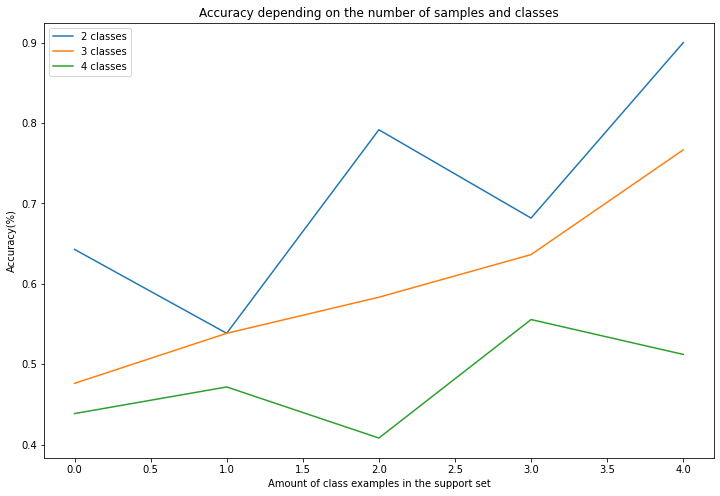

Accuracy of class 2[0.6428571428571429, 0.5384615384615384, 0.7916666666666666, 0.6818181818181818, 0.9]
Accuracy of class 3[0.47619047619047616, 0.5384615384615384, 0.5833333333333334, 0.6363636363636364, 0.7666666666666667]
Accuracy of class 4[0.43859649122807015, 0.4716981132075472, 0.40816326530612246, 0.5555555555555556, 0.5121951219512195]


In [ ]:
samples_min = 1
samples_max = 6
cl_min = 2
cl_max = 5 
model = model3    # model2 = word embedding model, model3 = sentence embedding model
embedding = transform_sentence2   # transform_sentence1 = word embedding transformation, transform_sentence2 = sentence embedding transformation
sim_func = classify_chebyshev_txt   # similarity measure (cosine, euclidean and chebyshev); only usefull for return_score1
pred_acc = return_score2    # return_score1 = prediction accuracy for cosine, euclidean and chebyshev, return_score2 = prediction accuracy for KNN                                                               

all_accuracy = {2:[],3:[],4:[]}

for num_samples in range(samples_min,samples_max):                          
  for num_cl in range(cl_min,cl_max):
    all_accuracy[num_cl].append(pred_acc(num_samples,num_cl,model,embedding,sim_func))


plt.figure(figsize=(12,8))
plt.plot(all_accuracy[2], label="2 classes")
plt.plot(all_accuracy[3], label="3 classes")
plt.plot(all_accuracy[4], label="4 classes")
plt.title("Accuracy depending on the number of samples and classes")
plt.xlabel("Amount of class examples in the support set")
plt.ylabel("Accuracy(%)")
plt.xticks()
plt.legend()
plt.show()

for i in range(cl_min, cl_max):
  print("Accuracy of class " + str(i) + str(all_accuracy[i]) )

# **References**


1.   **Dutch corpus**
      author = {Stephan Tulkens and Chris Emmery and Walter Daelemans},
      title = {Evaluating Unsupervised Dutch Word Embeddings as a Linguistic Resource},
      booktitle = {Proceedings of the Tenth International Conference on Language Resources and Evaluation (LREC 2016)},
      year = {2016},
      month = {may},
      date = {23-28},
      location = {Portorož, Slovenia},
      editor = {Nicoletta Calzolari (Conference Chair) and Khalid Choukri and Thierry Declerck and Marko Grobelnik and Bente Maegaard and Joseph Mariani and Asuncion Moreno and Jan Odijk and Stelios Piperidis},
      publisher = {European Language Resources Association (ELRA)},
      address = {Paris, France},
      isbn = {978-2-9517408-9-1},
      language = {english}
 }
2.   **Few-shot learning code**
https://maelfabien.github.io/machinelearning/NLP_5/#implementation


